# Generalized IF model

Generalized integrate-and-fire model is a spiking model, describes single neuron behavior and can generate several firing patterns.

In [8]:
import matplotlib.pyplot as plt
import brainpy as bp
import bpmodels
import pdb
from bpmodels.neurons import get_GeneralizedIF

In [9]:
# set parameters
num2mode = ["tonic_spiking",       "class_1",                           "spike_frequency_adaptation", 
            "phasic_spiking",      "accomodation",                      "threshold_variability", 
            "rebound spike",       "class_2",                           "integrator",      
            "input_bistability",   "hyperpolarization_induced_spiking", "hyperpolarization_induced_bursting",
            "tonic_bursting",      "phasic_bursting",                   "rebound_burst",                 
            "mixed_mode",          "afterpotentials",                   "basal_bistability",    
            "preferred_frequency", "spike_latency"]            

mode2param = {
    "tonic_spiking": {
        "input": [(1.5, 200.)]
    },
    "class_1": {
        "input": [(1. + 1e-6, 500.)]
    },
    "spike_frequency_adaptation": {
        "a": 0.005, "input": [(2., 200.)]
    },
    "phasic_spiking": {
        "a": 0.005, "input": [(1.5, 500.)]
    },
    "accomodation": {
        "a": 0.005, 
        "input": [(1.5, 100.), (0, 500.), (0.5, 100.), 
                  (1., 100.), (1.5, 100.), (0., 100.)]
    },
    "threshold_variability": {
        "a": 0.005, 
        "input": [(1.5, 20.), (0., 180.), (-1.5, 20.), 
                  (0., 20.), (1.5, 20.), (0., 140.)]
    },
    "rebound spike": {
        "a": 0.005, 
        "input": [(0, 50.), (-3.5, 750.), (0., 200.)]
    },
    "class_2": {
        "a": 0.005, 
        "input": [(2 * (1. + 1e-6), 200.)], 
        "V_th": -30.
    },
    "integrator": {
        "a": 0.005, 
        "input": [(1.5, 20.), (0., 10.), (1.5, 20.), (0., 250.),
                  (1.5, 20.), (0., 30.), (1.5, 20.), (0., 30.)]
    },
    "input_bistability": {
        "a": 0.005, 
        "input": [(1.5, 100.), (1.7, 400.), 
                  (1.5, 100.), (1.7, 400.)]
    },
    "hyperpolarization_induced_spiking": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "hyperpolarization_induced_bursting": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "A1": 10.,
        "A2": -0.6,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "tonic_bursting": {
        "a": 0.005, 
        "A1": 10.,
        "A2": -0.6,
        "input": [(2., 500.)]
    },
    "phasic_bursting": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(1.5, 500.)]
    },
    "rebound_burst": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(0, 100.), (-3.5, 500.), (0., 400.)]
    },
    "mixed_mode": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 500.)]
    },
    "afterpotentials": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 15.), (0, 185.)]
    },
    "basal_bistability": {
        "A1": 8.,
        "A2": -0.1,
        "input": [(5., 10.), (0., 90.), (5., 10.), (0., 90.)]
    },
    "preferred_frequency": {
        "a": 0.005,
        "A1": -3.,
        "A2": 0.5,
        "input": [(5., 10.), (0., 10.), (4., 10.), (0., 370.), 
                  (5., 10.), (0., 90.), (4., 10.), (0., 290.)]
    },
    "spike_latency": {
        "a": -0.08,
        "input": [(8., 2.), (0, 48.)]
    }
}

Define running function to simulate Generalized IF neuron group repeatedly (with specific mode).

In [10]:
def run_GeneralizedIF_with_mode(mode = "tonic_spiking", pos_row = 0, pos_col = 0, fig = None, gs = None):
    member_type = 0
    print(f"Choose parameters fit for <{mode}> mode")
    
    # build neuron group
    neu = bp.NeuGroup(GIF_neuron, geometry=(10,), monitors=['V', 'V_th', 'input'])
    neu.runner.set_schedule(['input', 'update', 'monitor', 'reset'])
    for (key, val) in mode2param[mode].items():
        if key == "input":
            I_ext, dur = bp.inputs.constant_current(val)
            member_type += 1
        else:
            if member_type==0:
                neu.pars[key] = val
            else:
                neu.ST[key] = val
    
    neu.run(duration = dur, inputs = ["ST.input", I_ext], report = False)
    
    ts = neu.mon.ts
    ax1 = fig.add_subplot(gs[pos_row, pos_col])
    ax1.title.set_text(f'{mode}')
    
    ax1.plot(ts, neu.mon.V[:, 0], label='V')
    ax1.plot(ts, neu.mon.V_th[:, 0], label='V_th')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane potential')
    ax1.set_xlim(-0.1, ts[-1] + 0.1)
    plt.legend()
    
    ax2 = ax1.twinx()
    ax2.plot(ts, neu.mon.input[:, 0], color = 'turquoise', label='input')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('External input')
    ax2.set_xlim(-0.1, ts[-1] + 0.1)
    ax2.set_ylim(-5., 20.)
    plt.legend(loc = 'lower left')

In [11]:
# set global params
dt = 0.02  # update variables per <dt> ms
duration = 200.  # simulate duration
bp.profile.set(backend="numba", dt=dt, merge_steps=True)

Import Generalized IF neuron model from bpmodels package. Simulate Generalized IF neuron groups to generate different spiking patterns.

Choose parameters fit for <tonic_spiking> mode
Choose parameters fit for <class_1> mode
Choose parameters fit for <spike_frequency_adaptation> mode
Choose parameters fit for <phasic_spiking> mode


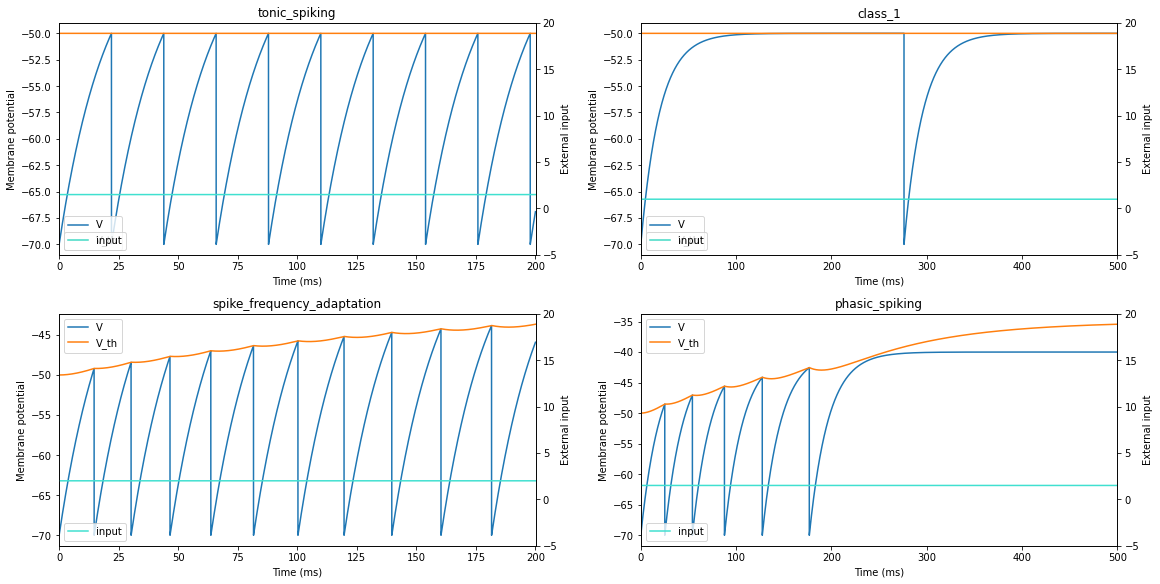

Choose parameters fit for <accomodation> mode
Choose parameters fit for <threshold_variability> mode
Choose parameters fit for <rebound spike> mode
Choose parameters fit for <class_2> mode


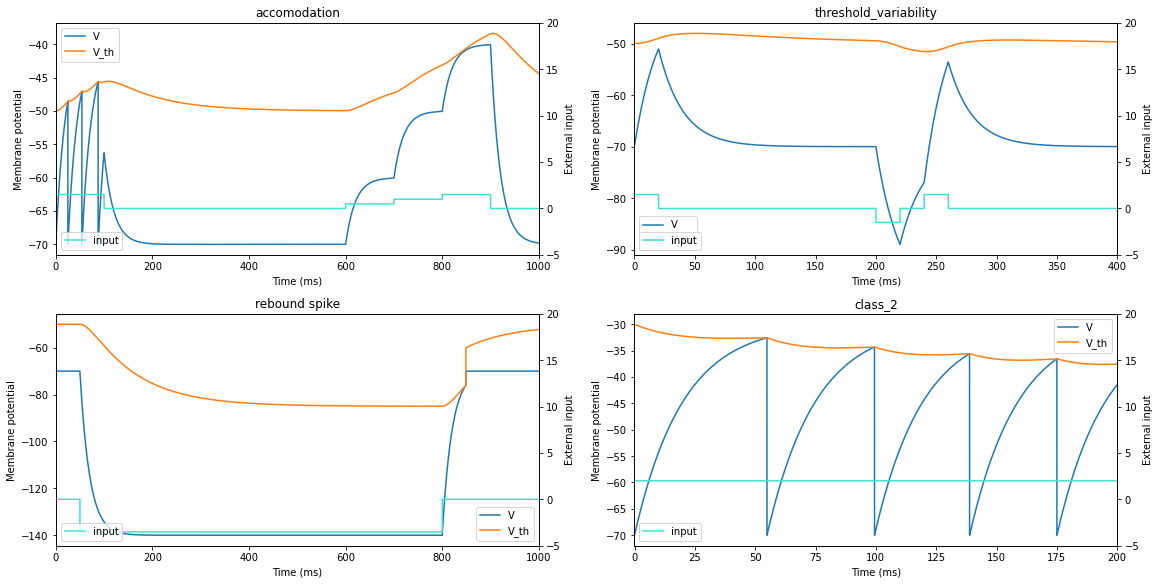

Choose parameters fit for <integrator> mode
Choose parameters fit for <input_bistability> mode
Choose parameters fit for <hyperpolarization_induced_spiking> mode
Choose parameters fit for <hyperpolarization_induced_bursting> mode


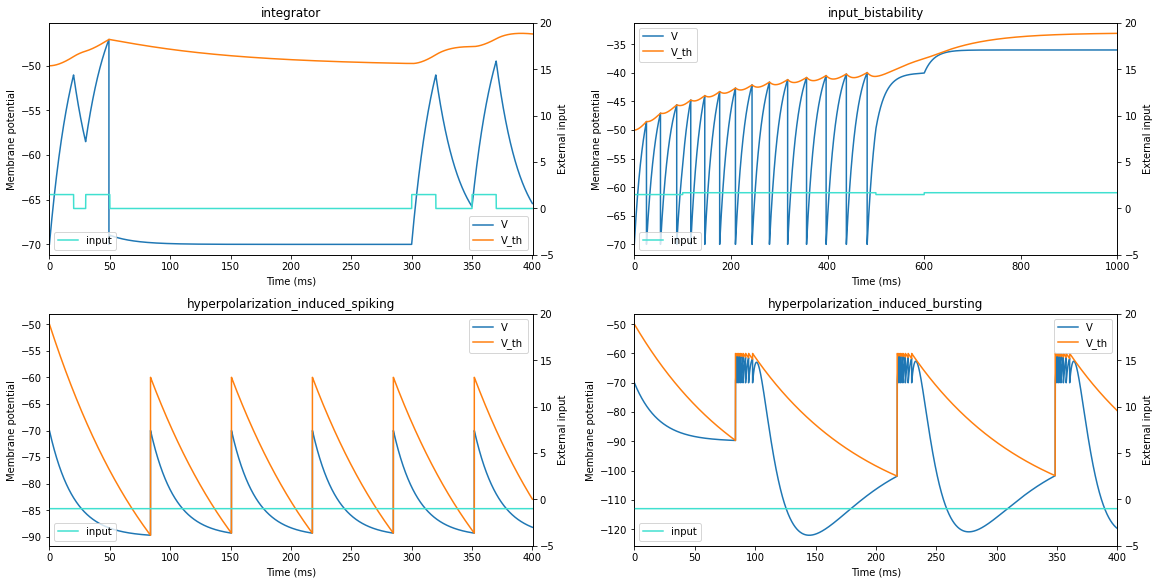

Choose parameters fit for <tonic_bursting> mode
Choose parameters fit for <phasic_bursting> mode
Choose parameters fit for <rebound_burst> mode
Choose parameters fit for <mixed_mode> mode


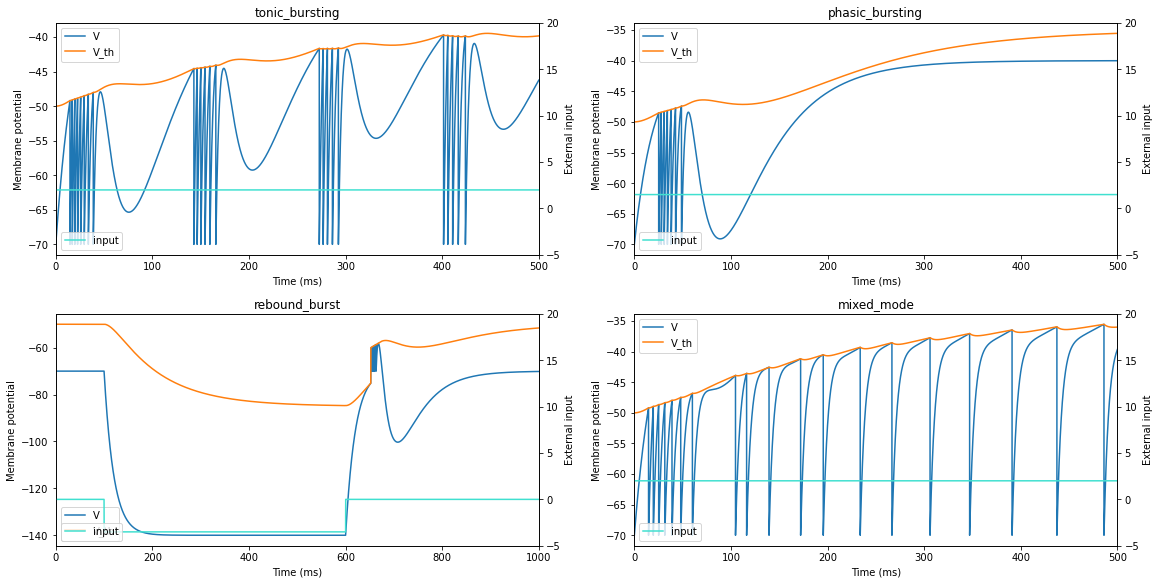

Choose parameters fit for <afterpotentials> mode
Choose parameters fit for <basal_bistability> mode
Choose parameters fit for <preferred_frequency> mode
Choose parameters fit for <spike_latency> mode


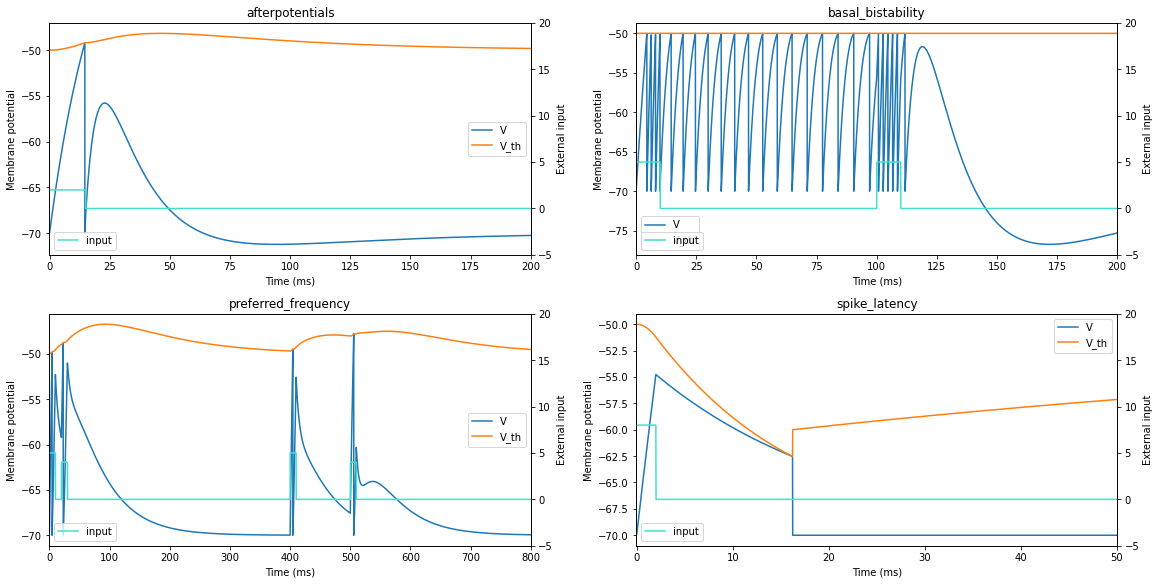

In [12]:
# define neuron type
GIF_neuron = get_GeneralizedIF(noise=1.)

# paint
show_all = False
size = 20
if show_all:
    row = 4
    column = 5
else:
    row = 2
    column = 2
batch_size = row * column
for i in range(size):
    if i%batch_size==0:
        fig, gs = bp.visualize.get_figure(row, column, 4, 8)
    mode = num2mode[i]
    run_GeneralizedIF_with_mode(mode, i%batch_size//column, i%batch_size%column, fig, gs)
    if (i+1)%batch_size==0:
        plt.show()